In [0]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/combined2_hNIL")

In [0]:
# required for umap clustering
! pip3 install leidenalg 
! pip3 install scanpy
# ! pip install python-igraph
# ! pip install louvain
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt


In [0]:
sc.settings.verbosity = 3 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.3 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.0


# Load the single cell object

In [0]:
# get the h5ad resulting from scanpy analysis
%ls scanpy_out/

combined2_hNIL_before_neighbors.h5ad  top_markers_pool2_hNIL.csv
combined2_hNIL.h5ad


In [0]:
# load the scanpy object which has been analyzed before
adata = sc.read("scanpy_out/combined2_hNIL.h5ad")

In [0]:
adata

AnnData object with n_obs × n_vars = 5697 × 2409 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

# Add my donor information from vireo_out

Note that here we use 7 donors because GT19-38452 and GT19-38451 are the same donor.

In [0]:
# get the genotyping infomation after cellSNP_vireo analysis
%ls vireo/vireo_out/

donor_ids.tsv                  _log.txt             prob_singlet.tsv.gz
fig_GT_distance_estimated.pdf  prob_doublet.tsv.gz  summary.tsv


In [0]:
# the cell barcode has been annotated using the donor_id by vireo
donors= pd.read_csv("vireo/vireo_out/donor_ids.tsv", '\t', index_col="cell")
donors = donors[["donor_id"]]
#add the column of "donor_label" for match donor_id to donor_label
donors["donor_label"] = donors["donor_id"]
donors.head(4)

,donor_id,donor_label
cell,,
AAACCCAAGGTGGTTG-1,GT19-38451,GT19-38451
AAACCCAAGTATTCCG-1,GT19-38446,GT19-38446
AAACCCAAGTGATTCC-1,GT19-38451,GT19-38451
AAACCCAAGTGTTGAA-1,GT19-38446,GT19-38446


In [0]:
donors.donor_id.value_counts()

GT19-38451    1404
GT19-38447    1020
GT19-38446     934
GT19-38445     769
GT19-38448     702
GT19-38449     398
doublet        349
GT19-38450     287
unassigned      31
Name: donor_id, dtype: int64

# get the metadata of the donors

In [0]:
%ls ../test_vireo/modify_donor/

'Copy of 19-Cel-005 Metadata.xlsx'   test_donor_to_use.vcf.gz
 meta_7Labels.csv                    test_donor.vcf
 meta_wgs_Psomagen.7Labels.csv       test_donor.vcf.gz
 meta_wgs_Psomagen.csv               test_donor.vcf.gz.tbi
 sedfnjT29                           test_today/
 sub_UNHS_changed.vcf.gz             UNHS_to_use_7s.vcf.gz
 sub_UNHS_changed.vcf.gz.tbi         UNHS_to_use.vcf.gz
 sub_UNHS_filter.vcf.gz              UNHS.vcf.gz
 sub_UNHS.vcf.gz                     UNHS.vcf.gz.csi
 sub_UNHS.vcf.gz.csi                 UNHS.vcf.gz.tbi
 test_cell.vcf.gz


In [0]:
# retrieve the 8 donor's original labels from metadata
meta = pd.read_csv("../test_vireo/modify_donor/meta_7Labels.csv")
meta=meta.loc[:, ["sample_id", "donor_label"]]
meta

,sample_id,donor_label
0,GT19-38445,KOLF2-ARID2-A02
1,GT19-38446,KUCG3-C1
2,GT19-38447,NCRM1-C6
3,GT19-38448,NCRM5-C5
4,GT19-38449,PGP1-C2
5,GT19-38450,LNGPI1-C1
6,GT19-38451,NN0003932-C3 or NN0004297-C1


# match donor_id to donor_label

In [0]:
# # match donor_id to donor_label
vals_to_replace = {'GT19-38445':'KOLF2-ARID2-A02', 
                   'GT19-38446':'KUCG3-C1', 
                   'GT19-38447':'NCRM1-C6',
                   'GT19-38448':'NCRM5-C5',
                   'GT19-38449':'PGP1-C2',
                   'GT19-38450':'LNGPI1-C1',
                   'GT19-38451':'NN0003932-C3 or NN0004297-C1',
                   'doublet': 'Doublet'
                   }

donors["donor_label"] = donors["donor_label"].map(vals_to_replace)

In [0]:
donors.head()

,donor_id,donor_label
cell,,
AAACCCAAGGTGGTTG-1,GT19-38451,NN0003932-C3 or NN0004297-C1
AAACCCAAGTATTCCG-1,GT19-38446,KUCG3-C1
AAACCCAAGTGATTCC-1,GT19-38451,NN0003932-C3 or NN0004297-C1
AAACCCAAGTGTTGAA-1,GT19-38446,KUCG3-C1
AAACCCACAATGCAGG-1,GT19-38451,NN0003932-C3 or NN0004297-C1


In [0]:
adata.obs.head()

,n_genes,percent_mito,n_counts,leiden
AAACCCAAGGTGGTTG-1,1798,0.034366,3550.0,10
AAACCCAAGTATTCCG-1,2327,0.049688,4810.0,5
AAACCCAAGTGATTCC-1,2105,0.053915,4266.0,1
AAACCCAAGTGTTGAA-1,3583,0.048324,9995.0,6
AAACCCACAATGCAGG-1,1875,0.042799,3902.0,3


In [0]:
# note that the row numbers of donor_subset and that of adata are not the same because adata has been filtered for doublets
print("cell numbers in donor_file are:", len(donors))
print("cell numbers in adata are:", len(adata.obs))

cell numbers in donor_file are: 5894
cell numbers in adata are: 5697


# merge donor_label to adata

In [0]:
# merge two dataframes
adata.obs = adata.obs.merge(donors, left_index=True, right_index=True)
adata.obs.head()

,n_genes,percent_mito,n_counts,leiden,donor_id,donor_label
AAACCCAAGGTGGTTG-1,1798,0.034366,3550.0,10,GT19-38451,NN0003932-C3 or NN0004297-C1
AAACCCAAGTATTCCG-1,2327,0.049688,4810.0,5,GT19-38446,KUCG3-C1
AAACCCAAGTGATTCC-1,2105,0.053915,4266.0,1,GT19-38451,NN0003932-C3 or NN0004297-C1
AAACCCAAGTGTTGAA-1,3583,0.048324,9995.0,6,GT19-38446,KUCG3-C1
AAACCCACAATGCAGG-1,1875,0.042799,3902.0,3,GT19-38451,NN0003932-C3 or NN0004297-C1


In [0]:
adata.obs.to_csv("scanpy_out/combined2_hNIL_adata_with_donors.csv")

# Export tables showing the matching frequences between clusters vs donor 


In [0]:
table = adata.obs.groupby(['donor_label'])['leiden'].agg(["count", "nunique", "unique"])
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
table

,count,nunique,unique
donor_label,,,
Doublet,341,16,"[1, 0, 2, 6, 10, ..., 8, 5, 11, 14, 15] Length: 16 Categories (16, object): [1, 0, 2, 6, ..., 5, 11, 14, 15]"
KOLF2-ARID2-A02,745,15,"[0, 2, 1, 8, 6, ..., 3, 11, 5, 7, 15] Length: 15 Categories (15, object): [0, 2, 1, 8, ..., 11, 5, 7, 15]"
KUCG3-C1,900,16,"[5, 6, 11, 1, 2, ..., 12, 15, 10, 14, 13] Length: 16 Categories (16, object): [5, 6, 11, 1, ..., 15, 10, 14, 13]"
LNGPI1-C1,274,11,"[5, 7, 2, 13, 4, ..., 0, 1, 3, 8, 14] Length: 11 Categories (11, object): [5, 7, 2, 13, ..., 1, 3, 8, 14]"
NCRM1-C6,974,16,"[14, 7, 8, 1, 0, ..., 9, 11, 12, 5, 15] Length: 16 Categories (16, object): [14, 7, 8, 1, ..., 11, 12, 5, 15]"
NCRM5-C5,680,16,"[0, 3, 8, 12, 11, ..., 6, 15, 9, 13, 14] Length: 16 Categories (16, object): [0, 3, 8, 12, ..., 15, 9, 13, 14]"
NN0003932-C3 or NN0004297-C1,1370,16,"[10, 1, 3, 9, 0, ..., 7, 4, 13, 14, 15] Length: 16 Categories (16, object): [10, 1, 3, 9, ..., 4, 13, 14, 15]"
PGP1-C2,384,14,"[5, 2, 3, 1, 4, ..., 6, 14, 7, 8, 13] Length: 14 Categories (14, object): [5, 2, 3, 1, ..., 14, 7, 8, 13]"


In [0]:
table.to_csv("scanpy_out/combined1_hNIL_donor_by_leiden.csv")

In [0]:
table2 = adata.obs.groupby(['leiden'])['donor_label'].agg(["count", "nunique", "unique"])
table2

,count,nunique,unique
leiden,,,
0,1065,8,"[NCRM5-C5, NN0003932-C3 or NN0004297-C1, KOLF2-ARID2-A02, Doublet, NCRM1-C6, PGP1-C2, KUCG3-C1, LNGPI1-C1, nan]"
1,681,8,"[NN0003932-C3 or NN0004297-C1, Doublet, NCRM1-C6, KUCG3-C1, PGP1-C2, NCRM5-C5, KOLF2-ARID2-A02, LNGPI1-C1, nan]"
2,528,8,"[NN0003932-C3 or NN0004297-C1, LNGPI1-C1, PGP1-C2, KUCG3-C1, KOLF2-ARID2-A02, NCRM1-C6, Doublet, NCRM5-C5, nan]"
3,459,8,"[NN0003932-C3 or NN0004297-C1, NCRM5-C5, PGP1-C2, KUCG3-C1, NCRM1-C6, KOLF2-ARID2-A02, Doublet, LNGPI1-C1, nan]"
4,442,8,"[PGP1-C2, NCRM1-C6, KUCG3-C1, NCRM5-C5, LNGPI1-C1, NN0003932-C3 or NN0004297-C1, KOLF2-ARID2-A02, Doublet]"
5,412,8,"[KUCG3-C1, LNGPI1-C1, PGP1-C2, NN0003932-C3 or NN0004297-C1, NCRM5-C5, KOLF2-ARID2-A02, NCRM1-C6, Doublet]"
6,327,8,"[KUCG3-C1, NN0003932-C3 or NN0004297-C1, NCRM1-C6, KOLF2-ARID2-A02, Doublet, LNGPI1-C1, NCRM5-C5, PGP1-C2]"
7,292,8,"[LNGPI1-C1, NCRM1-C6, NCRM5-C5, NN0003932-C3 or NN0004297-C1, KUCG3-C1, Doublet, KOLF2-ARID2-A02, PGP1-C2]"
8,287,8,"[NCRM1-C6, NCRM5-C5, NN0003932-C3 or NN0004297-C1, KOLF2-ARID2-A02, KUCG3-C1, Doublet, LNGPI1-C1, nan, PGP1-C2]"


In [0]:
table2.to_csv("scanpy_out/combined2_hNIL_leiden_by_donor.csv")
adata.write_h5ad("scanpy_out/combined2_hNIL_with_donors.h5ad")

... storing 'donor_id' as categorical
... storing 'donor_label' as categorical


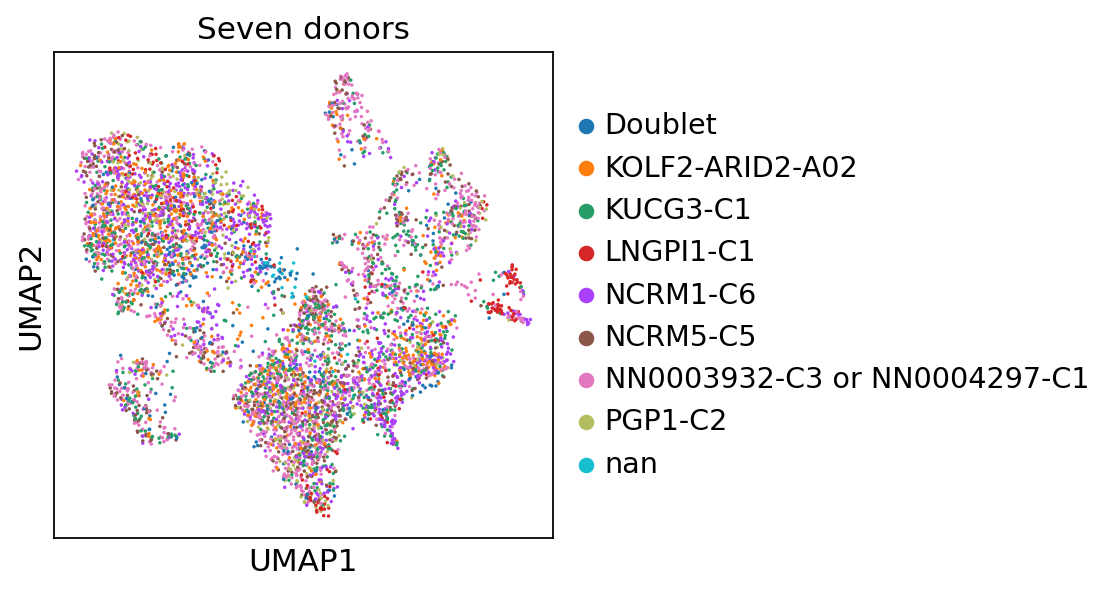

In [0]:
sc.pl.umap(adata, color=['donor_label'], title="Seven donors", size=10, save="_combined2_hNIL_donors.pdf")

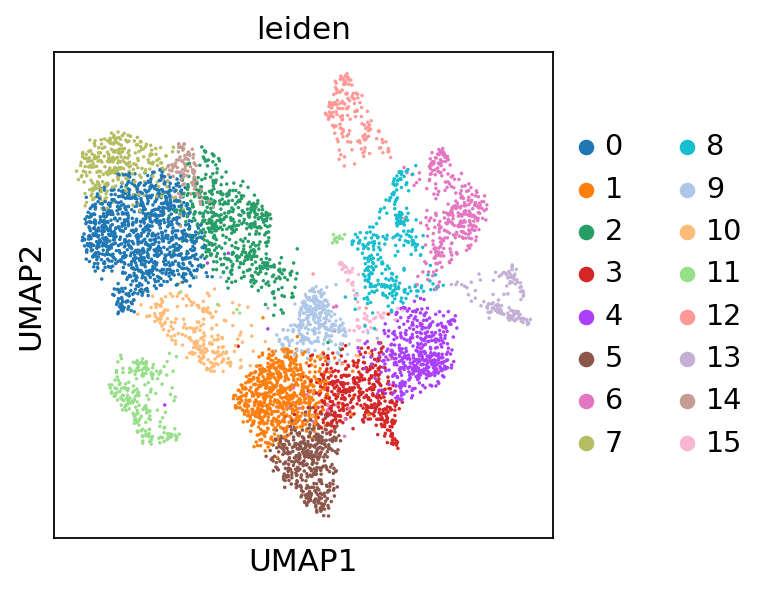

In [0]:
sc.pl.umap(adata, color=['leiden'], title="leiden", size=10, save="_combined2_hNIL_leiden.pdf")

In [0]:
labels = ['KOLF2-ARID2-A02',
 'KUCG3-C1',
 'NCRM1-C6',
 'NCRM5-C5',
 'PGP1-C2',
 'LNGPI1-C1',
 'NN0003932-C3 or NN0004297-C1', 'Doublet','nan']

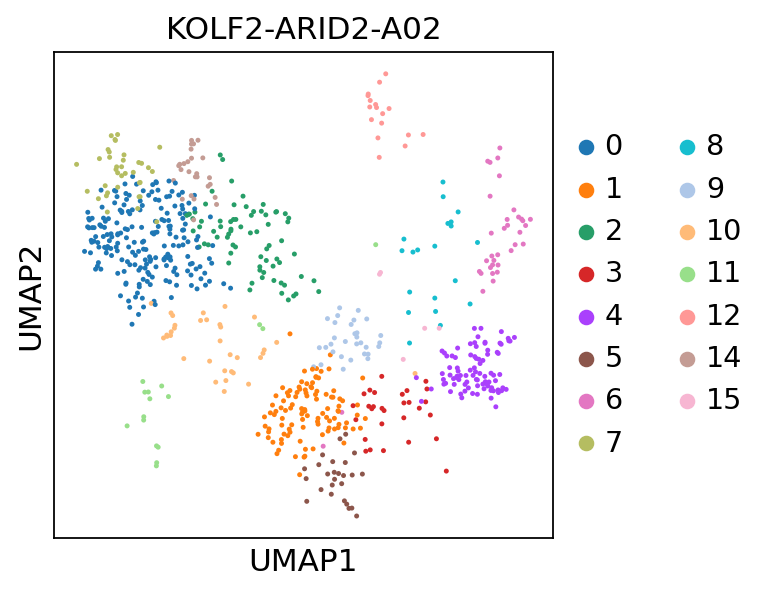

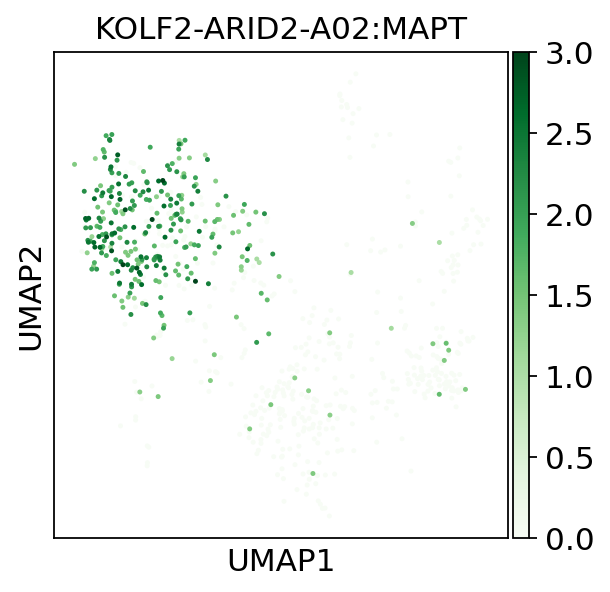

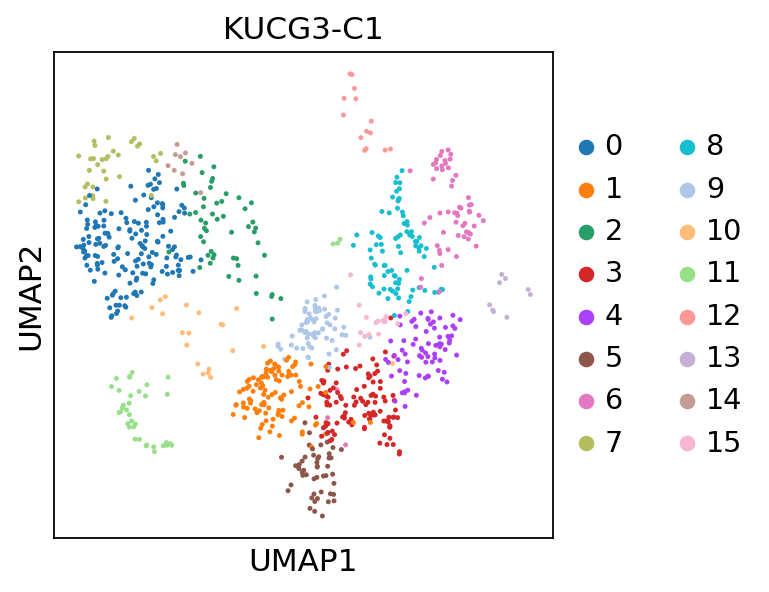

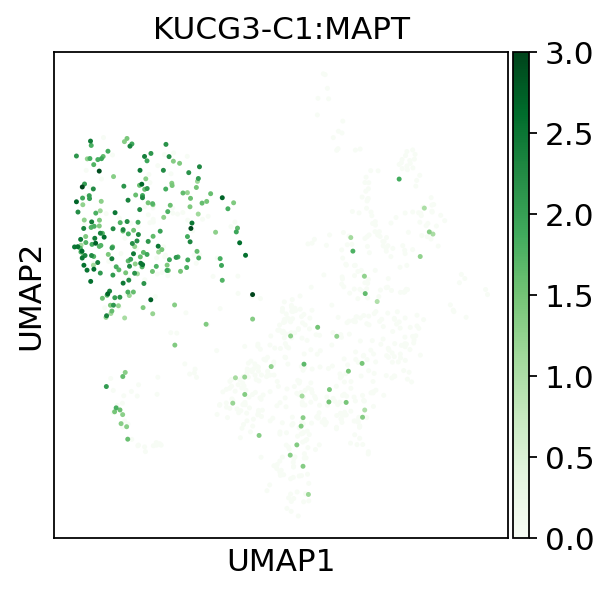

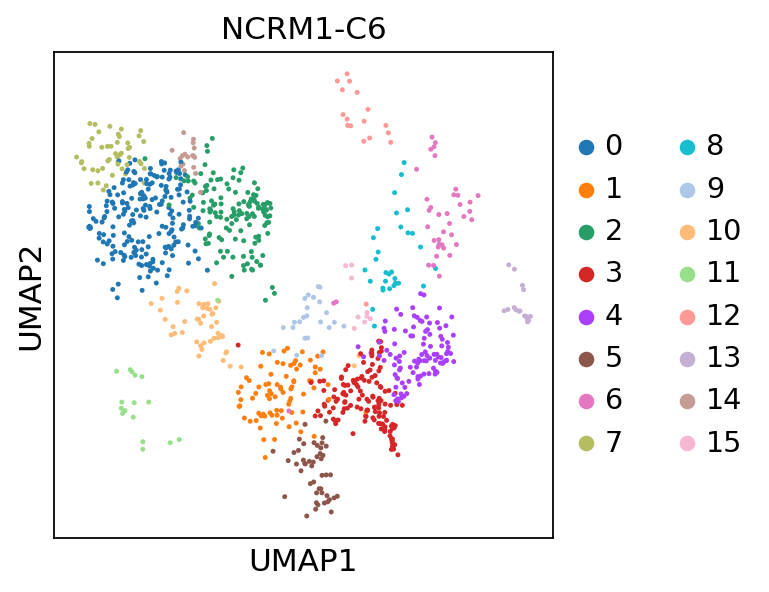

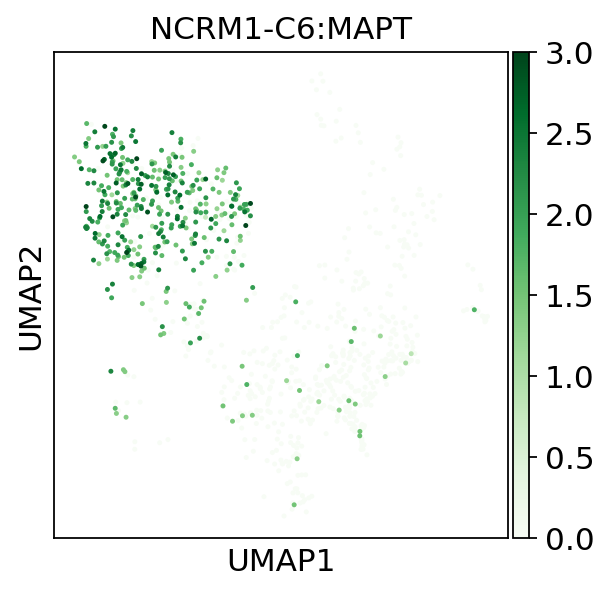

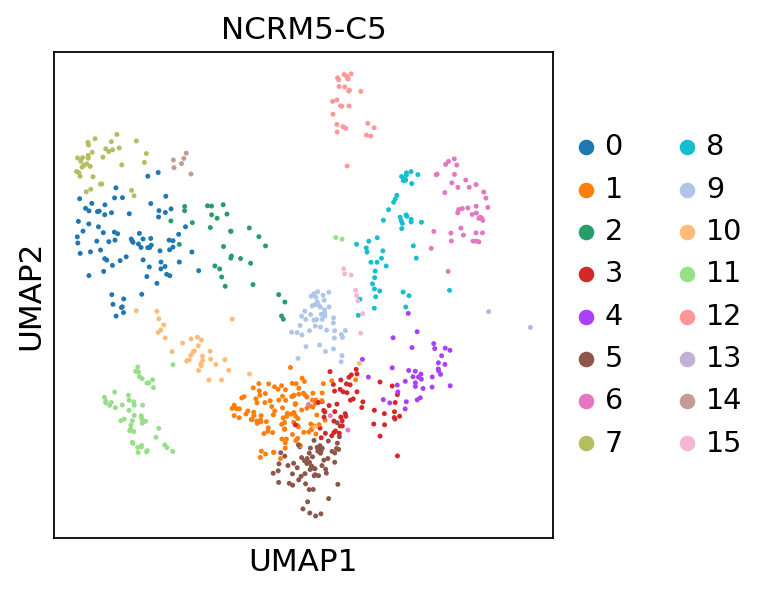

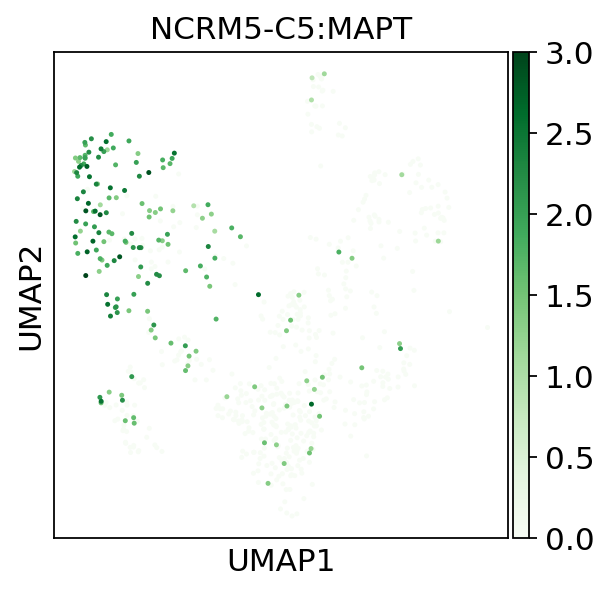

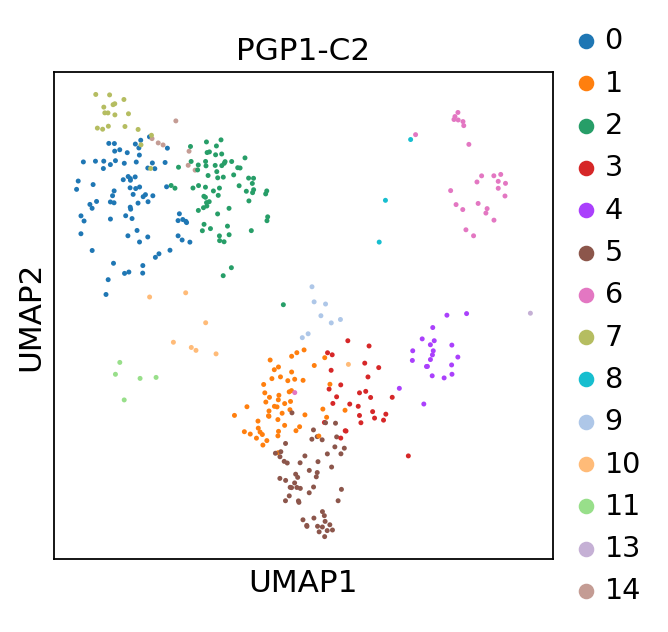

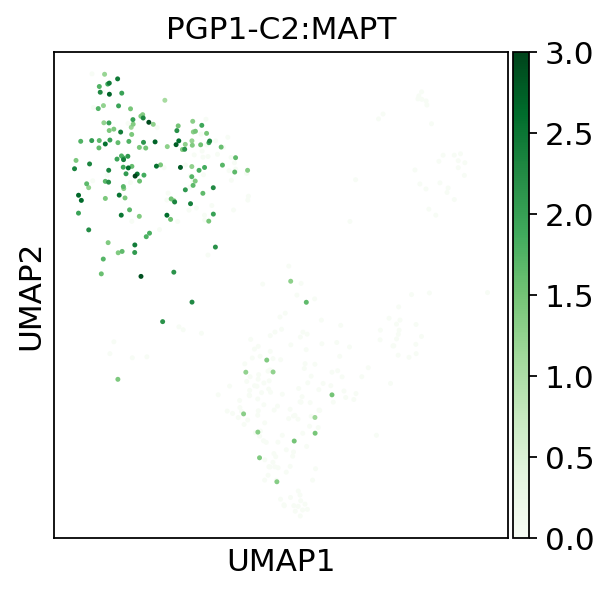

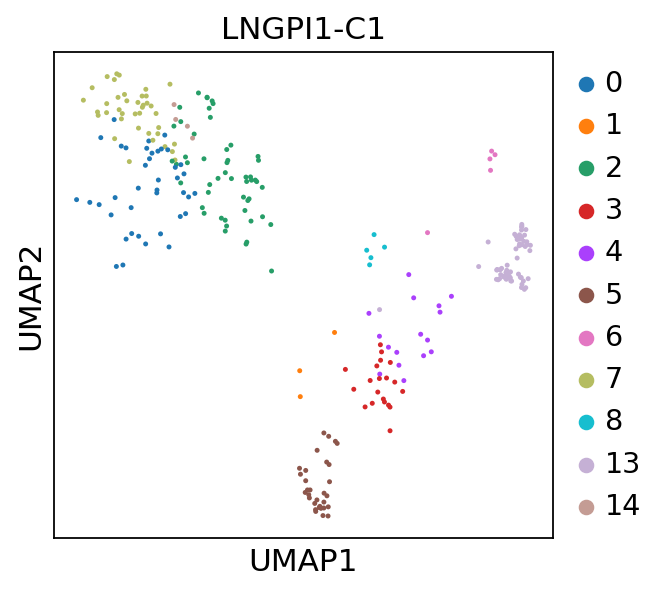

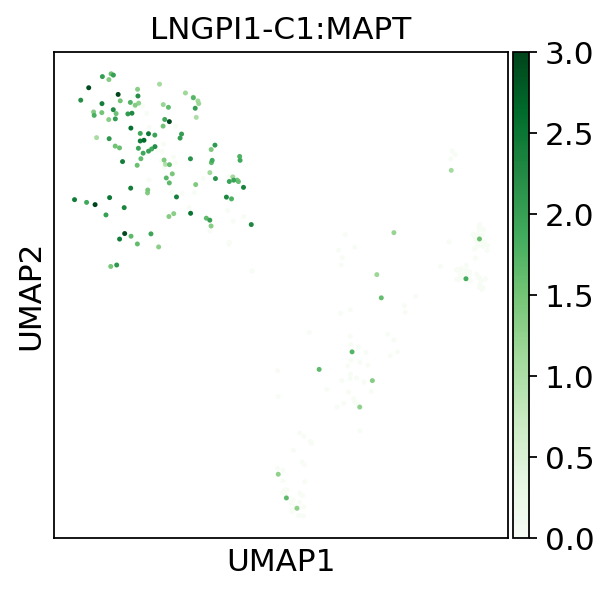

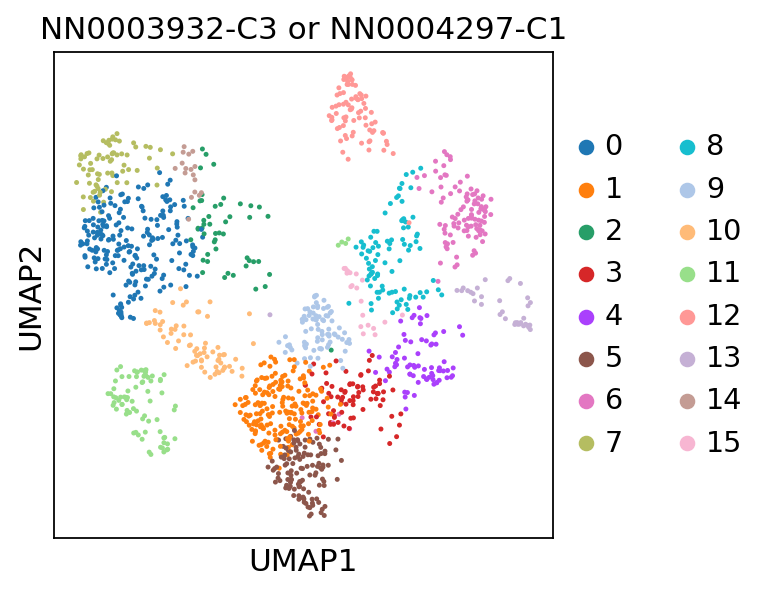

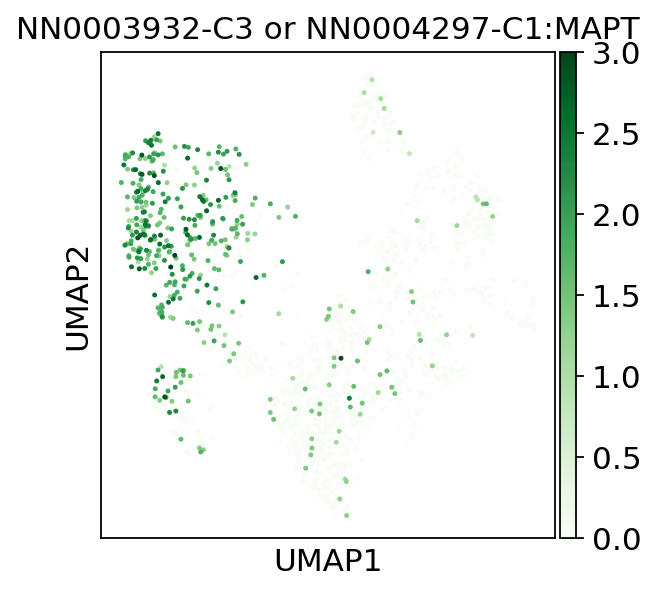

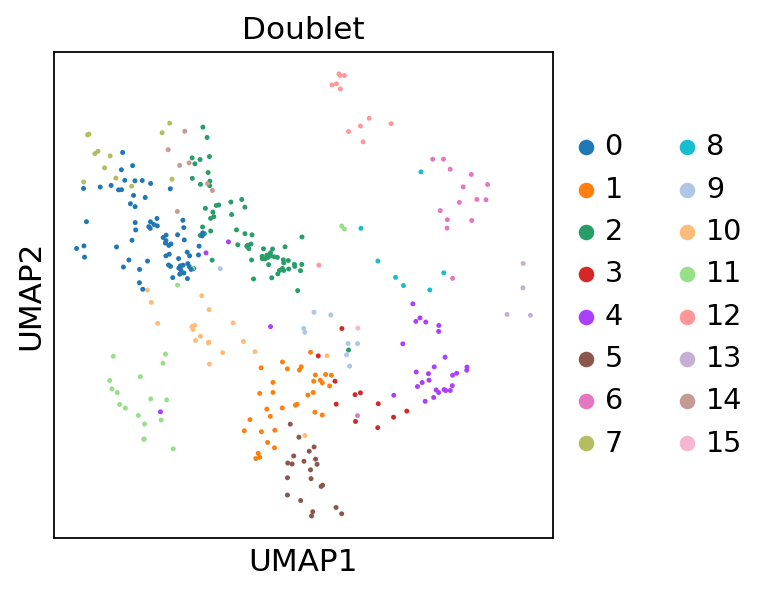

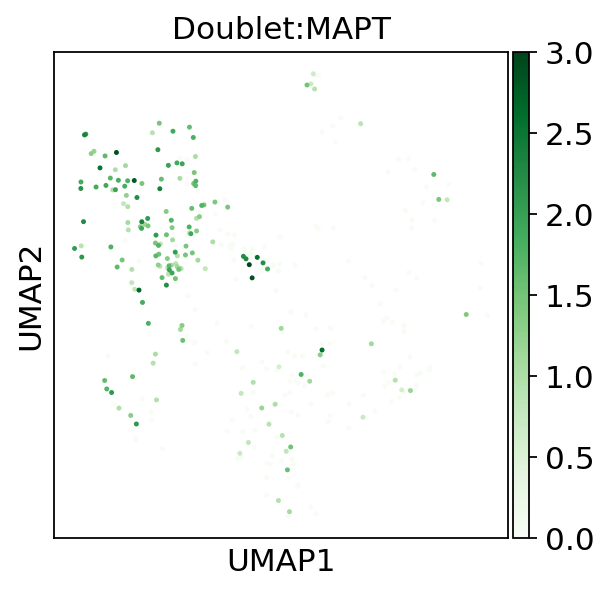

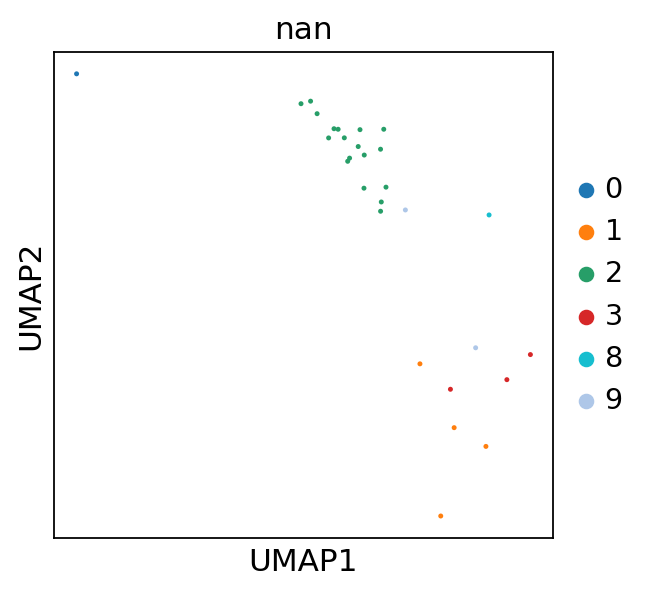

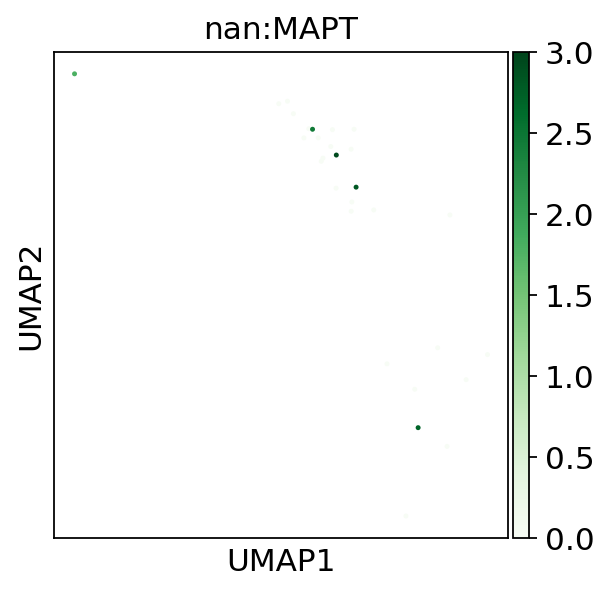

In [0]:
for i in labels:
  ax_title=i+":MAPT"
  ax = sc.pl.umap(adata[adata.obs["donor_label"] == i], color="leiden", color_map="Blues", title=i, size=20)
  sc.pl.umap(
    adata[adata.obs["donor_label"] == i],
    size=20,
    color=["MAPT"],
    color_map="Greens",
    vmax=3,
    title=ax_title,
    ax = ax
  )